# Overview

An overview of the data collected during our monitoring period. 

---

In this notebook we aim to investigate the distribution of tweets, retweets, replies, hashtags and links within our dataset. By doing this we hope to gain some understanding of the data we have collected. It will also allow us to determine how active the two distinct groups of users, journalists and news organisations, are on social media.

In [1]:
import collections
import json
import sys
import os
import requests
import bs4
import re
import matplotlib.pyplot as plt
import pandas as pd

# add penemue to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from utils import twiterate
from utils import Collect

%matplotlib inline

We begin by loading the user profiles, from the Twitter API, of each user contained within the original set of Twitter lists that we provided to Penemue when we begun our data collection. We then extract only the `id_str` of each user, classifying them into their two distinct groups using the appropriately named variables, journalists and organisations.

To do this we make use of the `Collect` class within the Penemue `utils`. By passing it a list of strings containing URLs of the Twitter lists we can begin to extract the user profiles by making rate limited calls to the Twitter API. Once the profiles have been collected, we then retrieve them using the `members` property of the class. As you can see below, our Twitter list URLs are stored in a JSON file so we must first open the appropriate file, then pass its contents to the `Collect` class. 

In [2]:
j = json.load(open('../data/journalists.json'))
journalists = [user['id_str'] for user in Collect(lists=j).members]    

Collecting...
Filtered: 4410
Users: 4410


Store each journalist `id_str` to a JSON file.

In [3]:
with open('../data/output/journalist_id_strs.json', 'w') as f:
    json.dump(journalists, f)

In [4]:
o = json.load(open('../data/organisations.json'))
organisations = [user['id_str'] for user in Collect(lists=o).members]

Collecting...
Filtered: 11
Users: 11


Store each organisation `id_str` to a JSON file.

In [5]:
with open('../data/output/organisation_id_strs.json', 'w') as f:
    json.dump(organisations, f)

Now that we have established our users of interest we can begin extracting some figures from the data. In order to present this data we'll define a couple of functions to chart the data as a pie chart of the distribution and a bar chart showing the top 10 occurances in the data.

In [6]:
def pie(joi, ooi):
    """Generate a pie chart of tweet distribution
    
    :param joi: A python list
                The list should contain 
                appropriate twitter profile 
                data.
    
    :param ooi: A python list
                The list should contain 
                appropriate twitter profile 
                data.
    """
    
    # calculate mean percentage
    joi_size = len(joi)
    ooi_size = len(ooi)
    total = joi_size + ooi_size

    joi_mean = (joi_size / total) * 100
    ooi_mean = (ooi_size / total) * 100

    # data to plot
    sizes = [joi_mean, ooi_mean]
    labels = "Journalists", "Organisations"
    colors = ['lightskyblue', 'lightcoral']
    
    # plot
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=True, startangle=90)

    plt.axis('equal')
    plt.show()

In [7]:
def bar(joi, ooi, label):
    """Generate a bar chart of the top 10
    occurances within the provided data
    
    :param joi:   A python list
                  The list should contain 
                  appropriate twitter profile 
                  data.
    
    :param ooi:   A python list
                  The list should contain 
                  appropriate twitter profile 
                  data.
                
    :param label: String
                  Label for the y-axis
    """
    
    # create list of users
    id_strs = ["@%s" % screen_name for screen_name in joi]
    id_strs += ["@%s" % screen_name for screen_name in ooi]

    # count occurances
    counter = collections.Counter(id_strs)
    most_common = counter.most_common(10)

    # data to plot
    labels, y = zip(*most_common)
    x = range(len(labels))
    
    # plot
    plt.bar(x, y, alpha=0.5)
    plt.xticks(x, labels, rotation='90')
    plt.ylabel(label)
    plt.show()

We begin by establishing the number of _original tweets_ authored by either a journalist of interest (`joi`) or a news organisation of interest (`ooi`) during the period of data collection. An original tweet is one that has been written and published by a user, such that it is not a reply nor a retweet.

In order to do this we make use of the `twiterate` function found in the Penemue `utils`. This function allows us to iterate through a JSON file of any size containing any number of [Tweet objects](https://dev.twitter.com/overview/api/tweets) by making use of a callback function. This callback accepts a single `tweet object` as a parameter and should return the attribute(s) of the tweet that we require. The reason for using such an approach is to avoid loading the full list of tweets into memory, which may lead to an out of memory exception as the number of tweets grows.

To determine whether a tweet is an _original tweet_ we must first check to see whether the tweet is a reply to another tweet and then check if the tweet is a retweet. As you can see in the callback function defined below, we do this using the `in_reply_to_status_id_str` attribute and the `retweeted_status` attribute of the tweet.

In [8]:
def get_original(tweet, search):
    """Identify original tweet
    
    :param tweet:  A tweet object
    :param search: A list of str_ids to search
    
    :return: A twitter screen_name as a string
    """
    
    if (tweet["user"]["id_str"] in search 
        and tweet["in_reply_to_status_id_str"] is None 
        and "retweeted_status" not in tweet):
            return tweet["user"]["screen_name"]

joi_originals = twiterate(lambda tweet : get_original(tweet, journalists))
ooi_originals = twiterate(lambda tweet : get_original(tweet, organisations))

[Progress] 
[======================================================================================================================================================================================================================]
[Progress] 
[===============================]


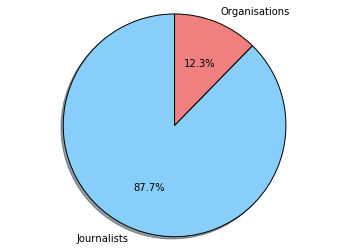

In [9]:
pie(joi_originals, ooi_originals)

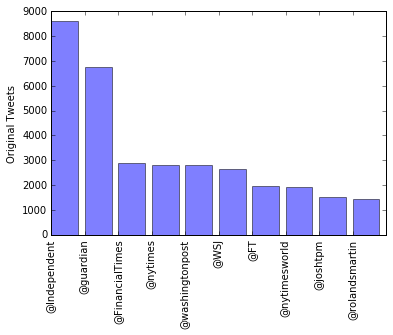

In [10]:
bar(joi_originals, ooi_originals, label="Original Tweets")

In [11]:
with open('../data/output/joi_originals.json', 'w') as f:
    json.dump(joi_originals, f)

In [12]:
with open('../data/output/ooi_originals.json', 'w') as f:
    json.dump(ooi_originals, f)

Next we will establish the number of retweets created by our users of interest throughout the period of data collection. To do this we define a new callback function that will this time only look at the `retweeted_status` of the tweet. According to the [Twitter documentation](https://dev.twitter.com/overview/api/tweets) a retweet can be identified by the presence of the `retweeted_status` attribute.

In [13]:
def get_retweet(tweet, search):
    """Identify a retweet
    
    :param tweet:  A tweet object
    :param search: A list of str_ids to search
    
    :return: A twitter screen_name as a string
    """
    
    if (tweet["user"]["id_str"] in search 
        and "retweeted_status" in tweet):
            return tweet["user"]["screen_name"]

joi_retweets = twiterate(lambda tweet : get_retweet(tweet, journalists))
ooi_retweets = twiterate(lambda tweet : get_retweet(tweet, organisations))

[Progress] 
[============================================================================================================================================================================================]
[Progress] 
[========]


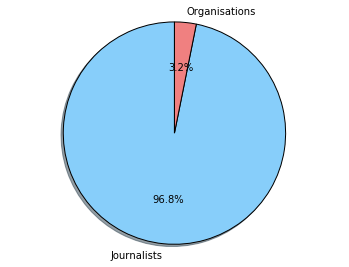

In [14]:
pie(joi_retweets, ooi_retweets)

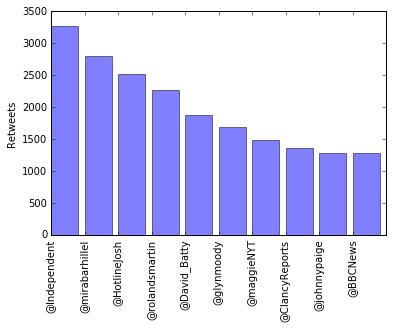

In [15]:
bar(joi_retweets, ooi_retweets, label="Retweets")

In [16]:
with open('../data/output/joi_retweets.json', 'w') as f:
    json.dump(joi_retweets, f)

In [17]:
with open('../data/output/ooi_retweets.json', 'w') as f:
    json.dump(ooi_retweets, f)

Similar to the process above, we will now determine the number of direct replies to other tweets were created during the period of data collection. To this we will define a callback that examines the `in_reply_to_status_id_str` attribute of a tweet. If the attribute is not `None` then we can classify it as a reply.

In [18]:
def get_reply(tweet, search):
    """Identify a reply
    
    :param tweet: A tweet object
    :param search: A list of str_ids to search
    
    :return: A twitter screen_name as a string
    """
    
    if (tweet["user"]["id_str"] in search 
        and tweet["in_reply_to_status_id_str"] is not None):
            return tweet["user"]["screen_name"]

joi_replies = twiterate(lambda tweet : get_reply(tweet, journalists))
ooi_replies = twiterate(lambda tweet : get_reply(tweet, organisations))

[Progress] 
[===============================================================================================================================]
[Progress] 
[]


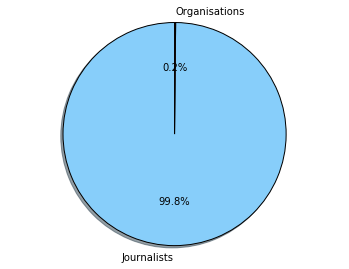

In [19]:
pie(joi_replies, ooi_replies)

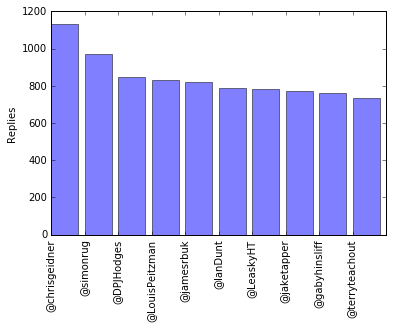

In [20]:
bar(joi_replies, ooi_replies, label="Replies")

In [21]:
with open('../data/output/joi_replies.json', 'w') as f:
    json.dump(joi_replies, f)

In [22]:
with open('../data/output/ooi_replies.json', 'w') as f:
    json.dump(ooi_replies, f)


Now that we have an idea of how active our users of interest are on social media, we thought it would be interesting to extract the most common content shared throughout the data collection period. Below we have extracted the top 10 links from all tweets in the dataset as well as the top 10 hashtags.

To extract the link from each tweet in the dataset we again look to the `twiterate` function. We must therefore define an appropriate callback to examine each tweet. Below you will notice that we are examining the `entities` attribute of the tweet to extract the `expanded_url`. For more information on how Twitter stores its tweet entities please see the [entities documentation](https://dev.twitter.com/overview/api/entities).

In [23]:
def get_url(tweet):
    """Extract urls from a tweet
    
    :param tweet: A tweet object
    :return: A url as a string
    """
    
    for url in tweet["entities"]["urls"]:
        return url["expanded_url"]

urls = twiterate(get_url)

[Progress] 
[===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Once we have extracted all of the links we must then establish the top 10 links that were shared and collect their associated title (i.e. the HTML `<title>` tag associated with that webpage). To do this we are going to define a new function `get_title` which we will call for the 10 most common links. This function will load the webpage using the provided link and extract the contents of its `<title>` tag.

In [24]:
def get_title(url):
    """Get the contents of title tag from
    the webpage at the link
    
    :param url: String containing a link
    :return: String containing page title
    """
    
    # get title text
    html = requests.get(url)
    page = bs4.BeautifulSoup(html.text, "html.parser")
    title = page.title.string if page.title != None else ""
    # remove markdown grammar
    title = re.sub(r"\r|\n|\||\s+", " ", title)
    # remove leading & trailing whitespace
    title = title.lstrip().rstrip()
    
    return title

In [25]:
lc = collections.Counter(urls)
mcl = [(url, get_title(url), occ) 
       for (url, occ) in lc.most_common(10)]

In [26]:
pd.DataFrame(mcl, 
             range(1, len(mcl) + 1), 
             ['Link', 'Title', 'Occurances'])

,Link,Title,Occurances
1,http://bbc.in/264XBZu,Corbyn ballot challenge ruling & Boris Johnson...,23546
2,http://bbc.co.uk/chilcot,The Chilcot report - BBC News,12441
3,http://bbc.in/29Ks0ns,As it happened: Turkey coup - BBC News,12430
4,http://bbc.in/29Hmy2f,Nice attack: Dozens killed during Bastille Day...,10140
5,http://dailym.ai/2aeYeXq,Victoria's new road safety ambassador Graham w...,8080
6,http://bbc.in/29IZoJa,Germany axe attack: Assault on train in Wuerzb...,6459
7,http://bbc.in/29jGj1l,Medina explosion: Suicide bombing near Saudi h...,6409
8,http://bbc.in/2a10eGn,Kabul explosion: Islamic State 'admits attack ...,6253
9,http://bbc.in/29OxgqY,Corbyn ballot challenge ruling & Boris Johnson...,5483
10,http://bbc.in/2a6az1f,German-Iranian teenager behind Munich shooting...,5215


In [27]:
pd.DataFrame([len(urls), len(set(urls))], 
             ['Total', 'Unique'], 
             ['Links'])

,Links
Total,5289657
Unique,334172


Next we will extract the top 10 hashtags from the dataset. To do this we simply look at the hashtag attribute within the entities object of the tweet and count the occurences of each hashtag.

In [28]:
def get_hashtag(tweet):
    """Extract hashtags from a tweet
    
    :param tweet: A tweet object
    :return: A list of hashtags
    """
    
    for hashtags in tweet["entities"]["hashtags"]:
        return hashtags["text"]
    
hashtags = twiterate(get_hashtag)
hc = collections.Counter(hashtags)
mch = [("#" + key, value) 
       for (key, value) in hc.most_common(10)]

[Progress] 
[===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

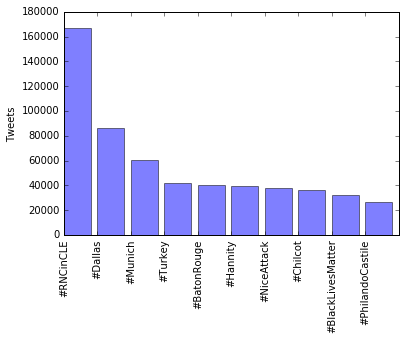

In [29]:
labels, y = zip(*mch)
x = range(len(labels))

plt.bar(x, y, alpha=0.5)
plt.xticks(x, labels, rotation='90')
plt.ylabel("Tweets")
plt.show()

While the data above might not provide us with any insight into the activity of our users of interest, it clearly highlights the discussions that took place during our monitoring window. With some further analysis, such as grouping journalists by hashtags, we may be able to build up a detailed picture about what exactly journalists are talking about and whether journalists stick to their domain of reporting or whether there is some cross over.